In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import h5py

In [3]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import io


# Load the Data

In [4]:
# Assign the data path.
data_path = "hin.txt"

# Read in the data.
lines = io.open(data_path, encoding = "utf-8").read().split("\n")
lines  = lines[:-1]
print(lines[1])
# Split the data into input and target sequences.
lines = [line.split("\t") for line in lines]
print(lines[0])
# We define the starting signal to be "\t" and the
# ending signal to be "\n". These signals tell the
# model that when it sees "\t" it should start
# producing its translation and produce "\n" when
# it wants to end its translation. Let us add
# "\t" to the start and "\n" to the end 
# of all input and output sentences.
lines = [("\t" + line[0] + "\n", "\t" + line[1] + "\n") for
            line in lines]

Jump.	उछलो.
['Help!', 'बचाओ!']


In [5]:
print (lines[0][1])

	बचाओ!



# Figure out the Best Lengths of Sentences

## Compute Sentence Lengths

In [6]:
# Compute the input and output lengths.
input_lengths = np.array([len(line[0]) for line in lines])
output_lengths = np.array([len(line[1]) for line in lines])

In [7]:
print(len(input_lengths))

2869


(75.0, 80.0, 0.0, 120.0)

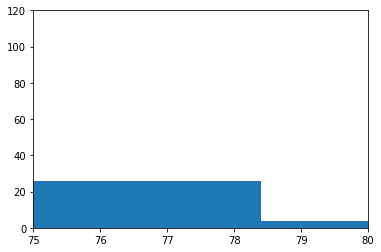

In [8]:
plt.hist(input_lengths)
plt.axis([75,80, 0 , 120])

(85.0, 89.0, 0.0, 20.0)

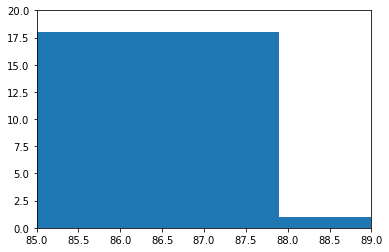

In [9]:
plt.hist(output_lengths)
plt.axis([85,89,0,20])

In [10]:
english = 78
hindi = 87

In [11]:
line1 = []
for i in range(len(input_lengths)):
    if(input_lengths[i]<75 and output_lengths[i]<85):
        line1 = line1 + [lines[i]]
        

In [12]:
print(len(line1))

2856


## Input Length

Plotted the histogram of the length of the input sentences and choose the length that makes the most sense. 

The reason we don't want sentences that are too long is because the computation becomes trickier for longer sentences and the performance also degrades. However we also want as many sentences in our dataset as possible.

Thus it is important to choose the right length and discard sentences longer than this.

## Output Length

Repeat the same for the lengths of the output sentences

In [13]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 2869  # Number of samples to train on.

In [14]:
input_texts = [(line[0]) for line in line1]
target_texts = [(line[1]) for line in line1]

In [15]:
input_characters = set()
target_characters = set()

In [16]:
for input_text in input_texts:
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)

for target_text in target_texts:
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [18]:
print( len(input_characters))
print( len(target_characters))

72
92


In [19]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [20]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 2856
Number of unique input tokens: 72
Number of unique output tokens: 92
Max sequence length for inputs: 74
Max sequence length for outputs: 82


In [21]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [22]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [23]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [24]:

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [25]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')


In [26]:
epochs = 100

In [27]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=batch_size,epochs=epochs,validation_split=0.2)

Epoch 1/100
36/36 [==============================] - 49s 1s/step - loss: 1.2814 - val_loss: 2.0101
Epoch 2/100
36/36 [==============================] - 36s 999ms/step - loss: 1.2184 - val_loss: 2.0068
Epoch 3/100
36/36 [==============================] - 36s 1s/step - loss: 1.2129 - val_loss: 1.9766
Epoch 4/100
36/36 [==============================] - 37s 1s/step - loss: 1.2029 - val_loss: 1.9887
Epoch 5/100
36/36 [==============================] - 36s 999ms/step - loss: 1.1952 - val_loss: 1.9671
Epoch 6/100
36/36 [==============================] - 36s 1s/step - loss: 1.1920 - val_loss: 2.0451
Epoch 7/100
36/36 [==============================] - 36s 1s/step - loss: 1.2503 - val_loss: 1.9707
Epoch 8/100
36/36 [==============================] - 36s 999ms/step - loss: 1.1775 - val_loss: 1.9477
Epoch 9/100
36/36 [==============================] - 36s 1s/step - loss: 1.1841 - val_loss: 1.9748
Epoch 10/100
36/36 [==============================] - 38s 1s/step - loss: 1.1588 - val_loss: 1.9080


36/36 [==============================] - 21s 591ms/step - loss: 0.7420 - val_loss: 1.3629
Epoch 82/100
36/36 [==============================] - 35s 986ms/step - loss: 0.7424 - val_loss: 1.3866
Epoch 83/100
36/36 [==============================] - 36s 992ms/step - loss: 0.7325 - val_loss: 1.3590
Epoch 84/100
36/36 [==============================] - 36s 994ms/step - loss: 0.7307 - val_loss: 1.3952
Epoch 85/100
36/36 [==============================] - 35s 985ms/step - loss: 0.7289 - val_loss: 1.3476
Epoch 86/100
36/36 [==============================] - 36s 998ms/step - loss: 0.7267 - val_loss: 1.3668
Epoch 87/100
36/36 [==============================] - 35s 981ms/step - loss: 0.7289 - val_loss: 1.3535
Epoch 88/100
36/36 [==============================] - 36s 998ms/step - loss: 0.7189 - val_loss: 1.3398
Epoch 89/100
36/36 [==============================] - 36s 996ms/step - loss: 0.7244 - val_loss: 1.3756
Epoch 90/100
36/36 [==============================] - 36s 998ms/step - loss: 0.7147 - 

In [28]:
model.save('s2s.h5')


In [29]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [30]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence


In [31]:
for seq_index in range(100):
    
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print(input_texts[seq_index])
    print(decoded_sentence)

-
	Help!

यह किताब है।

-
	Jump.

मुझे उसके पास कर को किया है।

-
	Jump.

मुझे उसके पास कर को किया है।

-
	Jump.

मुझे उसके पास कर को किया है।

-
	Hello!

यह किताब है।

-
	Hello!

यह किताब है।

-
	Cheers!

उसने मुझे को को को को को को को से नहीं है।

-
	Cheers!

उसने मुझे को को को को को को को से नहीं है।

-
	Got it?

मुझे उसके पास कर को किया।

-
	I'm OK.

मैं तुम्हें को किताब है।

-
	Awesome!

मुझे उसके पास कर को किया।

-
	Come in.

मुझे उसके पास कर को किया।

-
	Get out!

मुझे उसके पास कर को किया है।

-
	Go away!

हम रहा है।

-
	Goodbye!

मुझे उसके पास कर को किया।

-
	Perfect!

मुझे उसके पास कर को किया है।

-
	Perfect!

मुझे उसके पास कर को किया है।

-
	Welcome.

हम रहा है।

-
	Welcome.

हम रहा है।

-
	Have fun.

मुझे उसके पास कर को किया।

-
	Have fun.

मुझे उसके पास कर को किया।

-
	Have fun.

मुझे उसके पास कर को किया।

-
	I forgot.

मैं तुम्हें को किताब है।

-
	I forgot.

मैं तुम्हें को किताब है।

-
	I'll pay.

मैं तुम्हें को किताब है।

-
	I'm fine.

मैं तुम्हें को किताब है।

-
	I'm ful